In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
sns.set_style(style="darkgrid")
warnings.filterwarnings(action="ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [11]:
df = pd.read_csv(r"D:\Python\data analysis projects\loan-approval-classification-data\HR_comma_sep.csv")
df.sample(frac=0.002, random_state=42).head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
6723,0.65,0.96,5,226,2,1,0,0,marketing,medium
6473,0.88,0.80,3,166,2,0,0,0,IT,low
4679,0.69,0.98,3,214,2,0,0,0,sales,low
862,0.41,0.47,2,154,3,0,1,0,sales,low
7286,0.87,0.76,5,254,2,1,0,0,hr,low


In [12]:
df.isna().sum()[df.isna().sum() > 0]

Series([], dtype: int64)

In [13]:
print(df.shape)
df.info()

(14999, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [14]:
df["left"].value_counts()

left
0    11428
1     3571
Name: count, dtype: int64

In [15]:
df["Department"].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

**The majority of Department take the low and medium salary**


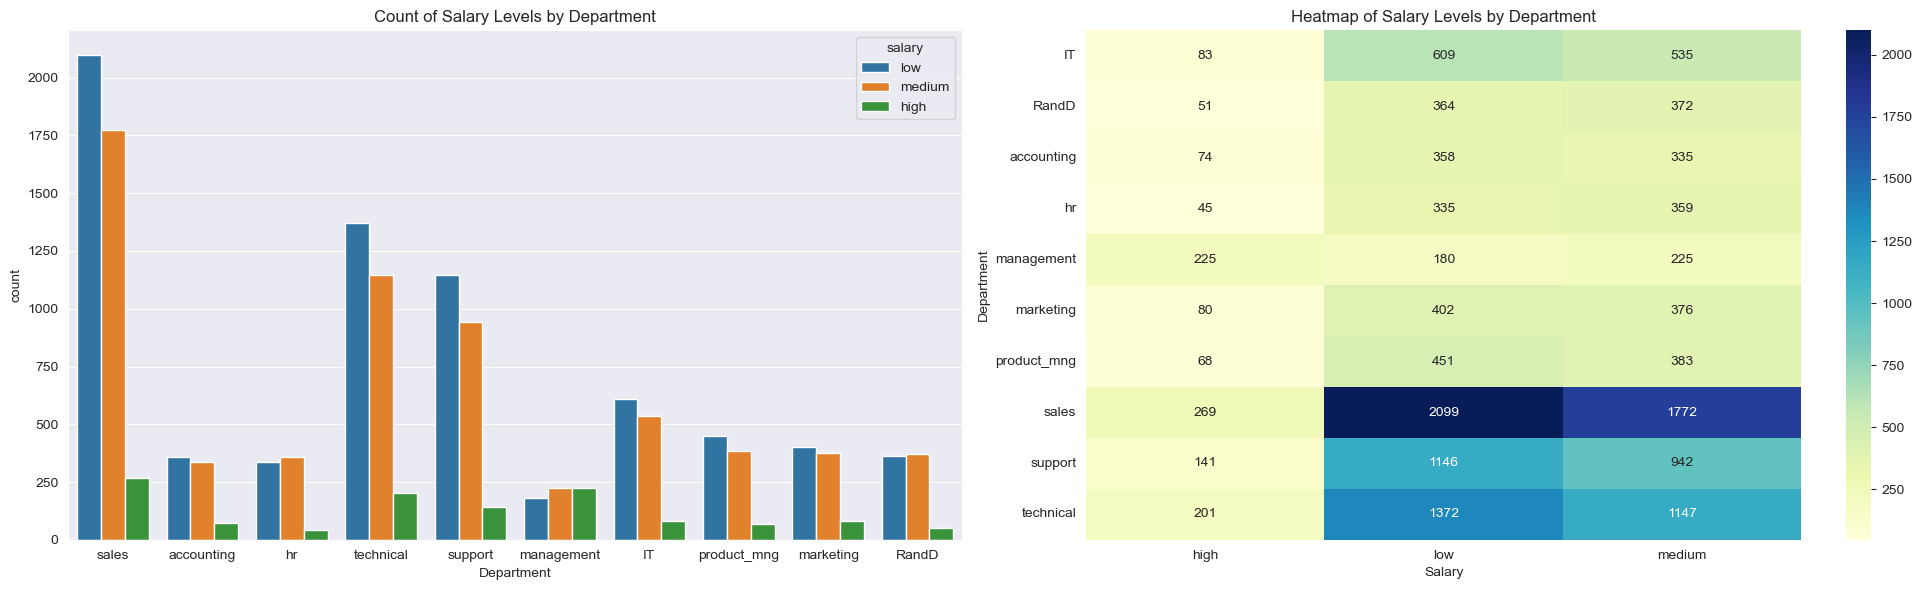

In [16]:
department_salary = df.pivot_table(index="Department", columns="salary", aggfunc="size")

plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
sns.countplot(x='Department', hue='salary', data=df)
plt.title(label="Count of Salary Levels by Department")
plt.tight_layout()



plt.subplot(1,2,2)
sns.heatmap(data=department_salary, annot=True, cmap="YlGnBu", fmt="d")

plt.title(label="Heatmap of Salary Levels by Department")
plt.ylabel(ylabel="Department")
plt.xlabel(xlabel="Salary")
plt.tight_layout()

plt.show()

(14999, 10)


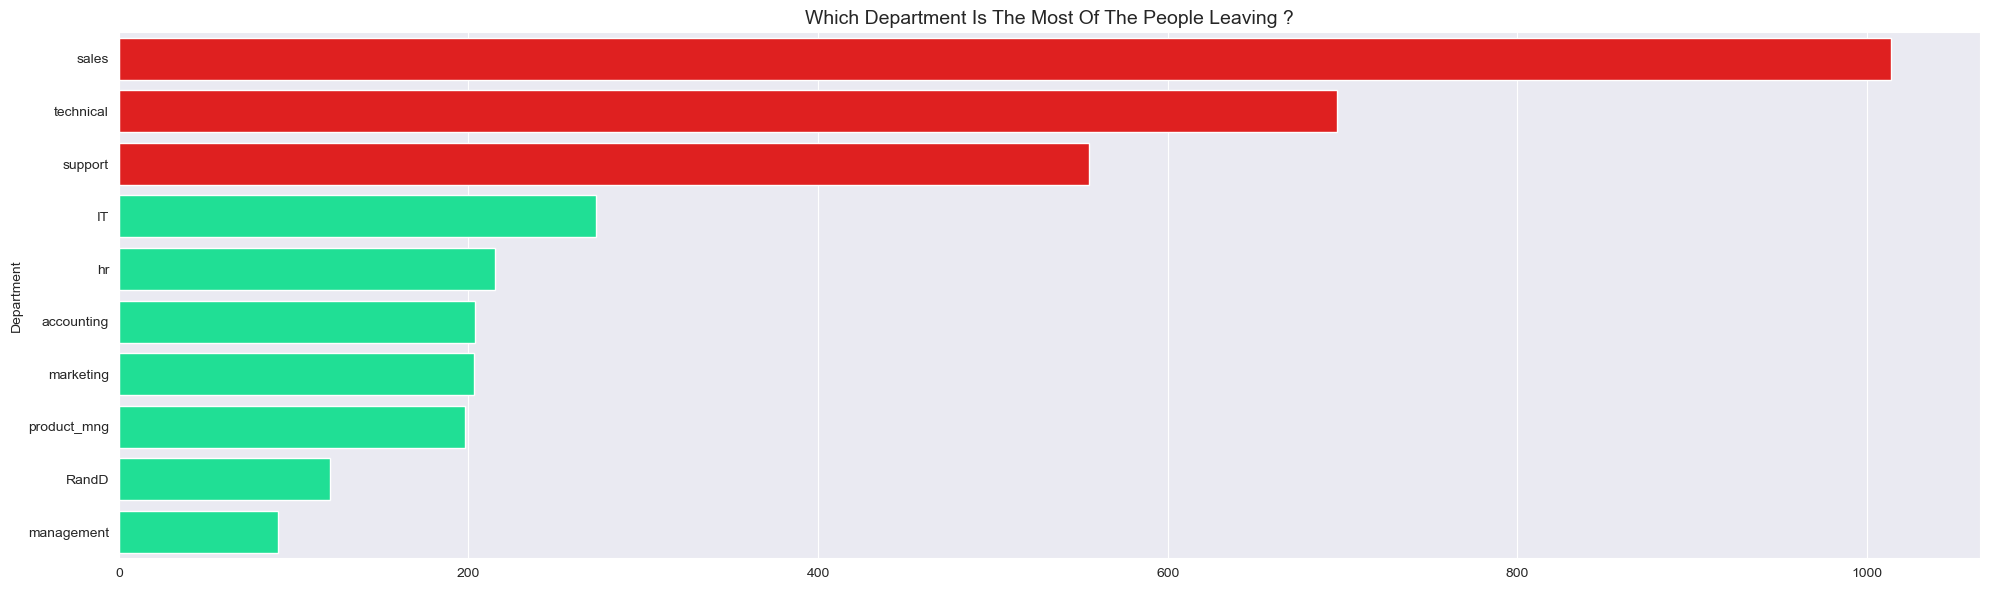

In [17]:
print(df.shape)
df[df["left"] == 1]["Department"].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(
    x=df[df["left"] == 1]["Department"].value_counts().values, 
    y=df[df["left"] == 1]["Department"].value_counts().index, orient="h",
    palette=["red"] * 3 + ["#00FF9C"] * 7 
)

plt.title("which department is the most of the people leaving ?".title(), fontsize=14)
plt.tight_layout()
plt.show()

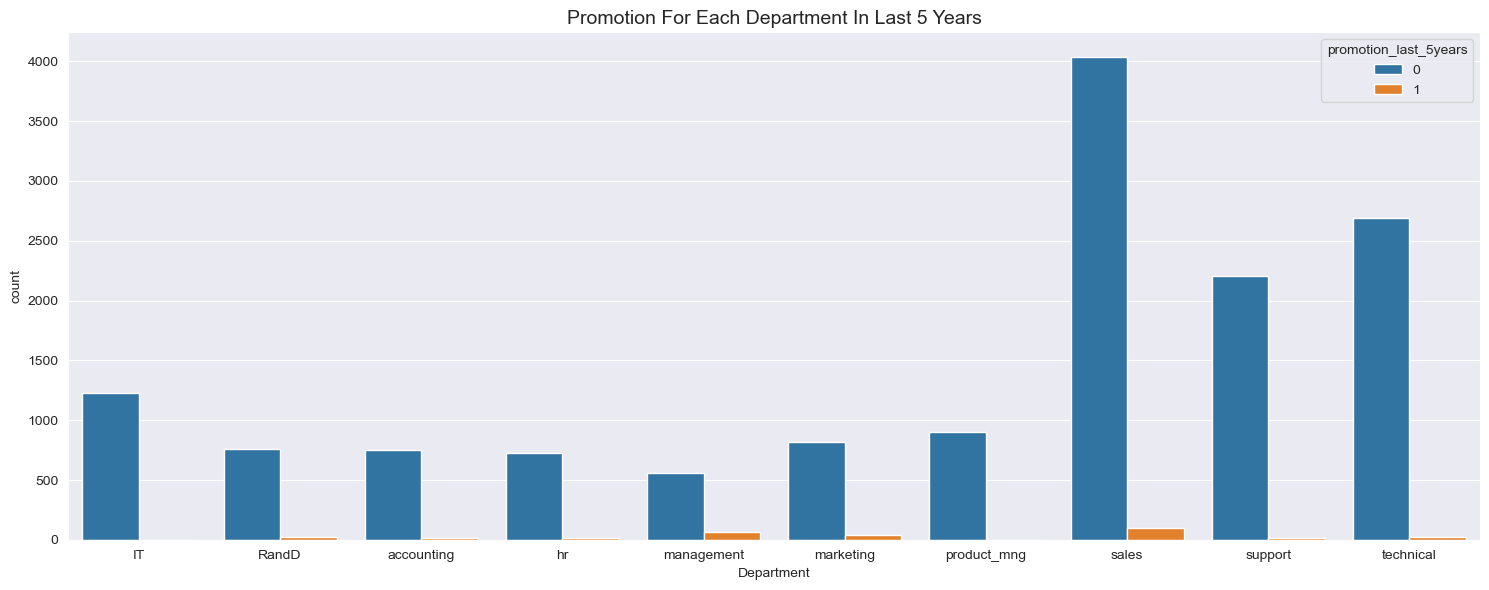

In [18]:
df[df["promotion_last_5years"] > 0]

plt.figure(figsize=(15,6))
promotion = df.pivot_table(index="Department", columns="promotion_last_5years", aggfunc="size", fill_value=0)
promotion_long = promotion.reset_index().melt(id_vars="Department", var_name="promotion_last_5years", value_name="count")
sns.barplot(data=promotion_long, x="Department", y="count", hue="promotion_last_5years")
plt.title("promotion for each department in last 5 years".title(), fontsize=14)
plt.tight_layout()
plt.show()

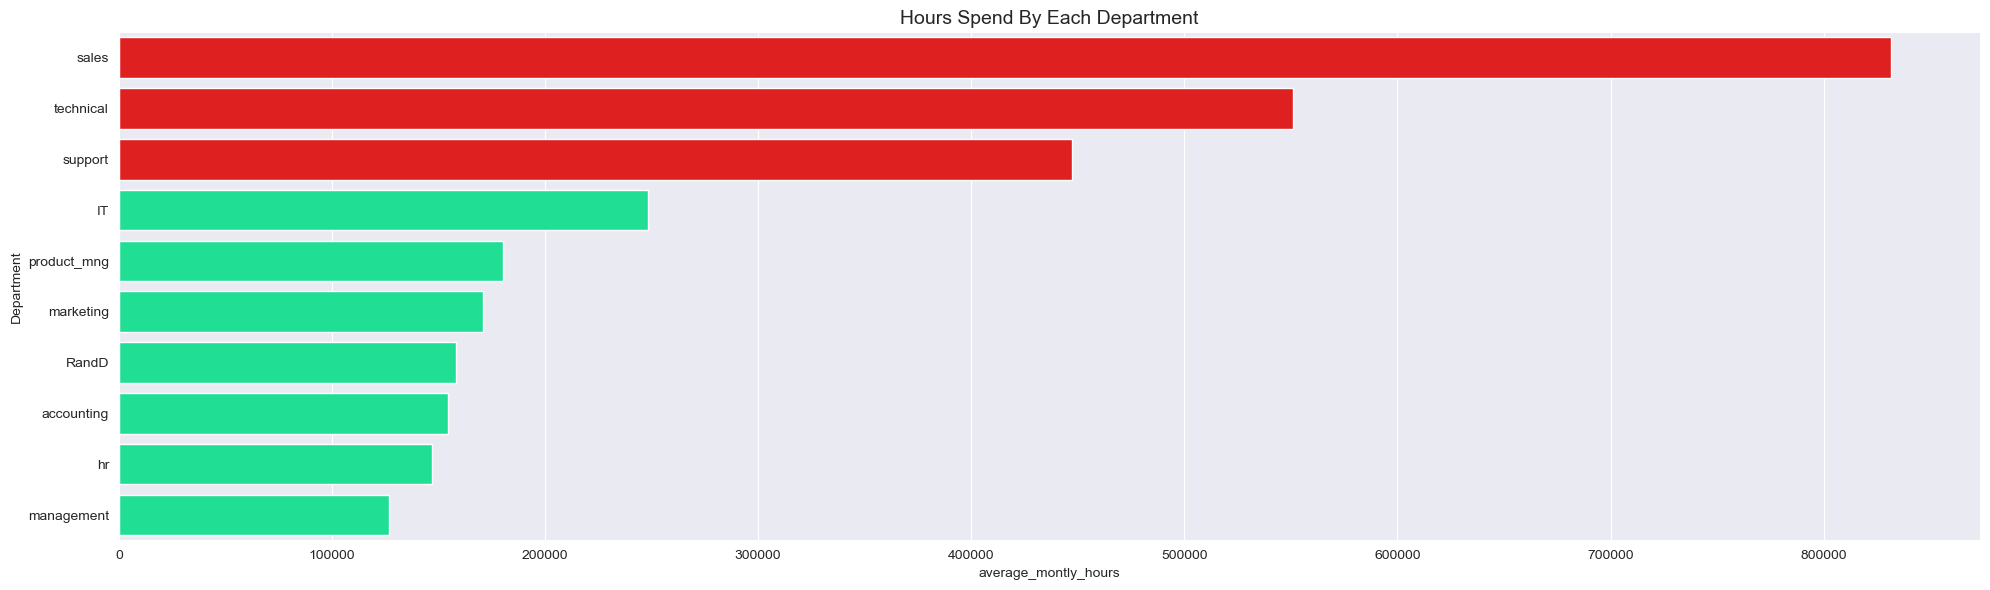

In [19]:
hours_per_month = df.groupby(by="Department")["average_montly_hours"].sum().reset_index()
hours_per_month = hours_per_month.sort_values(by="average_montly_hours", axis=0, ascending=False)
plt.figure(figsize=(20, 6))
sns.barplot(data=hours_per_month, x="average_montly_hours", y="Department", orient="h", palette=["red"] * 3 + ["#00FF9C"] * 7)
plt.title(label="hours spend by each department".title(), fontsize=14)
plt.tight_layout()
plt.show()

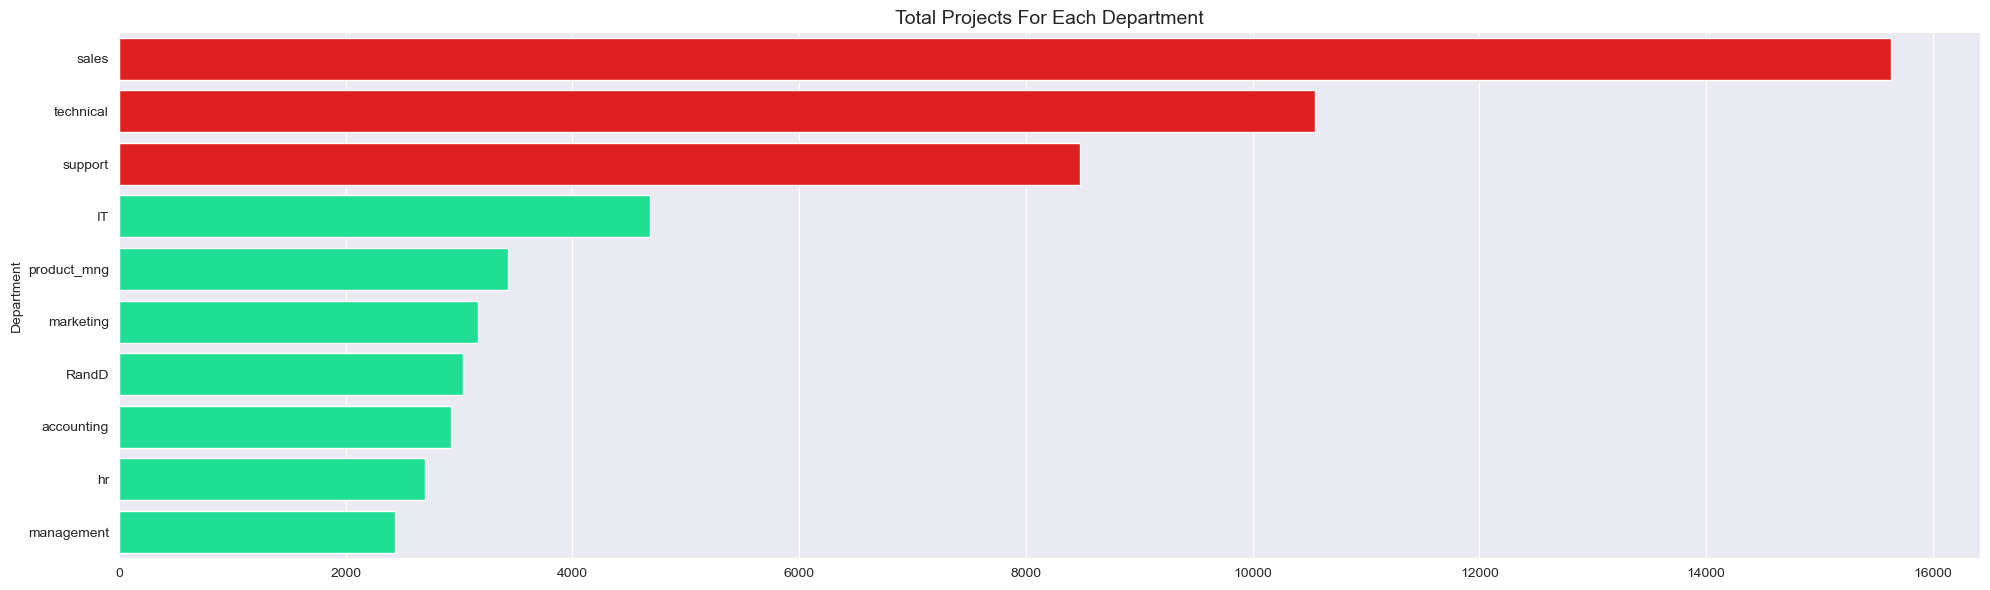

In [20]:
number_of_projects = df.groupby(by="Department")["number_project"].sum().sort_values(ascending=False)

plt.figure(figsize=(20, 6))
sns.barplot(x=number_of_projects.values, y=number_of_projects.index, orient="h", palette=["red"] * 3 + ["#00FF9C"] * 7)
plt.title(label="total projects for each department".title(), fontsize=14)
plt.tight_layout()
plt.show()

In [21]:
df

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
14994,0.40,0.57,2,151,3,0,1,0,support,low
14995,0.37,0.48,2,160,3,0,1,0,support,low
14996,0.37,0.53,2,143,3,0,1,0,support,low
14997,0.11,0.96,6,280,4,0,1,0,support,low


In [22]:
import plotly.express as px
from category_encoders import CatBoostEncoder

fig = px.box(data_frame=df, x="last_evaluation", y="Department", color="Department")

# Add title and description
fig.update_layout(
    title="Distribution of Last Evaluation by Department",
    height=550,
    title_x=0.5,  # Center the title
    xaxis_title="Last Evaluation Score",
    yaxis_title="Department",
    annotations=[
        dict(
            text="This box plot shows the distribution of last evaluation scores across different departments.",
            xref="paper",
            yref="paper",
            x=0.5,
            y=-0.15,  # Position below the x-axis
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

In [23]:
df.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


Mean After Using 10 Stratifiedkfold


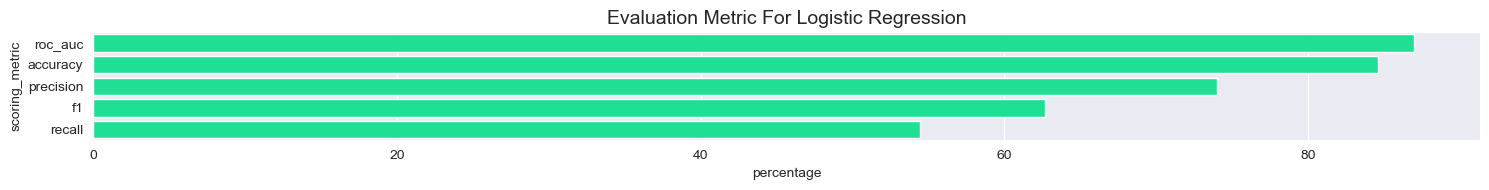

In [24]:
s_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df1 = df.copy()

salary_dummies = pd.get_dummies(data=df["salary"]).astype(dtype=np.int64)
df1 = pd.concat(objs=[df.iloc[:, :-1], salary_dummies], axis=1)

category_encoder = CatBoostEncoder(cols="Department", random_state=42)
dummy_frame = category_encoder.fit_transform(X=df1.drop(columns="left"), y=df1["left"])
df1["Department"] = dummy_frame["Department"]

X = df1.drop(labels="left", axis=1)
y = df["left"]
evaluation_metric: list[str] = ["accuracy","f1","precision","recall","roc_auc"]
results = []

for eval_met in evaluation_metric:
    cv = cross_validate(
        estimator=LogisticRegression(),
        X=X,
        y=y,
        cv=s_kf,
        n_jobs=-1,
        scoring=eval_met,
        return_train_score=False
    )
    output = {
        "model": "LogisticRegression",
        "scoring_metric": eval_met,
        "Mean" : np.mean(cv["test_score"]),
        "percentage" : np.round(np.mean(cv["test_score"]) * 100, 2)
    }
    
    results.append(output)
    
print("mean after using 10 StratifiedKFold".title())
results = pd.DataFrame(results).replace(np.nan, 0).sort_values(by="percentage", ascending=False)
results

plt.figure(figsize=(15,2))
sns.barplot(data=results, x="percentage", y="scoring_metric", orient="h", color="#00FF9C")
plt.title(label="Evaluation Metric For Logistic Regression", fontsize=14)
plt.tight_layout()
plt.show()

In [25]:
import os



X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, train_size=0.3, random_state=101)

logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)

# Get the predicted probabilities
predicted_probabilities = logistic_regression.predict_proba(X_test)

# Save probabilities to a file
with open(os.path.join(os.getcwd(), "probability.txt"), mode="w") as file:
    # Convert the array to a string format that is readable
    for prob in predicted_probabilities:
        file.write(f"{prob[0]:.4f}, {prob[1]:.4f}\n")  # Adjust formatting as needed



              precision    recall  f1-score   support

           0       0.87      0.94      0.90      8000
           1       0.74      0.53      0.62      2500

    accuracy                           0.84     10500
   macro avg       0.80      0.74      0.76     10500
weighted avg       0.84      0.84      0.83     10500



<Axes: >

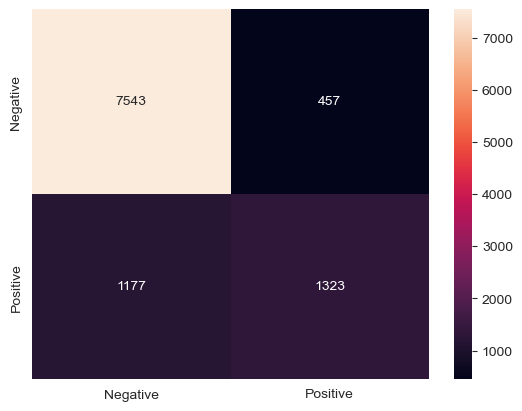

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict = logistic_regression.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_predict))

cm = confusion_matrix(y_true=y_test, y_pred=y_predict)
sns.heatmap(data=cm, annot=True, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], fmt="d")

In [33]:
const_x = sm.add_constant(X, has_constant="add")
model = sm.Logit(endog=y, exog=const_x).fit()
vif_df = pd.DataFrame()
# check for multicollinearity
vif_df["feature"] = const_x.columns
vif_df["vif"] = [variance_inflation_factor(exog=const_x.values, exog_idx=i) for i in range(const_x.shape[1])]

with open(os.path.join(os.getcwd(), "Logit Result.txt"), mode="w") as file:
    file.write(f"{model.summary()}\n\n")
    file.write(f"{vif_df}\n\n")
    file.write(f"{classification_report(y_true=y_test, y_pred=y_predict)}\n\n")

         Current function value: 0.359459
         Iterations: 35
